# Recreational Areas In Los Angeles
#### Kayla Chaoui z5214021 https://github.com/kchaoui

Data provided by the California Department of Parks and Recreation and the U.S. 2010 Census.

The dataset published by the California Department of Parks and Recreation lists the recreational facilities in the LA city area including details of their type, locations and council association. This analysis incorporated the 2010 Census data for LA which was comprised of each zip code's population, median age and households.

The data can be found from the following locations:
* Recreational Facilities: https://catalog.data.gov/dataset/department-of-recreation-and-parks-facility-and-park-information-e7cff 
* Census Data: https://data.lacity.org/dataset/2010-Census-Populations-by-Zip-Code/nxs9-385f

## Pre-Analysis of Data

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import numpy as np
import pandas as pd
import os
import geopandas as gp
import shapely
import fiona
import squarify
from descartes import PolygonPatch

### Configuring Global Plot Settings 

In [2]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (20, 10)
saved_style_state = matplotlib.rcParams.copy() 
plt.rc('font',family='avenir')

plt.rc('font', size=12)     
plt.rc('axes', titlesize= 20)     
plt.rc('axes', labelsize=15)    
plt.rc('xtick', labelsize=15)    
plt.rc('ytick', labelsize=15)    
plt.rc('legend', fontsize=12)   
plt.rc('figure', titlesize=40) 

plt.style.use('fivethirtyeight')

### Importing and Cleaning Data
The two sets of data required some cleaning to make it more usable including ensuring all data points where indeed in the LA city area and shortening some of the column names.

In [3]:
#Getting data from file path
def getdata(filepath):
    if os.path.isfile(filepath):

        print("loading from file")
        print("done")
    else:
        print("Put ur file there")
    return(pd.read_csv(filepath, low_memory=False))

In [4]:
dfrec_data= getdata("park_info.csv")
print(dfrec_data[dfrec_data['Zip']== 92325].index.values)
dfrec_data=dfrec_data.drop(dfrec_data.index[855]) #removes the 92325 zip code, it is not in the LA city region so it has no census data


dfcensus = getdata("census.csv")
dfcensus_data=dfcensus.rename(columns=({'Zip Code':'Zip','Total Population':'Population','Median Age':'MedianAge',
                                        'Total Males':'Males','Total Females':'Females','Total Households':'Households',
                                        'Average Household Size':'AvgHouseholdSize'}))

dfrec_data.GeoLong=dfrec_data.GeoLong.apply(lambda x:x if x < -118 else None) #this cleaned the data, there were outliers that affected the mapping and graphing of the data
#dfrec_data.GeoLong.hist()

loading from file
done
[855]
loading from file
done


### Merging Data Sets
The below code combines summary data from the park data and adds it into the census data format, this was to ensure that correlational analysis could be easily completed. Also, two forms of the data frame were formed, dfmerged_data has a standard numerical index and dfmerged_data2 uses the zip code as the index. Separating them made it easier to create certain plots that were more complex such as the stacked plot or the layered bar and line graph. 

In [5]:
counts=dfrec_data["Zip"].value_counts()
reccounts = pd.DataFrame(counts)
reccounts["new_column"] = reccounts.index
reccounts.reset_index(drop=True, inplace=True)
reccounts=reccounts.rename(columns=({'Zip':'Total_Count','new_column': 'Zip'}))
columns_titles = ["Zip","Total_Count"]
reccounts=reccounts.reindex(columns=columns_titles)

zipinfo=pd.DataFrame(dfcensus_data)

dfmerged_data= pd.merge(zipinfo,reccounts, on="Zip")

locTypes=dfrec_data.LocationType.tolist()
locTypes = list(dict.fromkeys(locTypes))

for facility in locTypes:
    parks = dfrec_data["Zip"][dfrec_data["LocationType"] == facility].value_counts()
    parkcounts = pd.DataFrame(parks)
    parkcounts[f"{facility}"] = parkcounts.index
    parkcounts.reset_index(drop=True, inplace=True)
    parkcounts=parkcounts.rename(columns=({'Zip':f"{facility}",f"{facility}": 'Zip'}))
   
    dfmerged_data= pd.merge(dfmerged_data,parkcounts, on="Zip", how='outer') 
    dfmerged_data=dfmerged_data.fillna(0)

dfmerged_data2=dfmerged_data.copy(deep=True)
dfmerged_data2.set_index('Zip',inplace=True)

The different facility types were categorised into Outdoor, Indoor and Combined facilities to form its own data frame, assumptions had to be made to group the facilities into categories. This is used later for the tree plots.

In [6]:
outdoor= pd.DataFrame(dfmerged_data2['Parks'] + dfmerged_data2['Gardens'] +dfmerged_data2['Outdoor Fitness Equipment']
          +dfmerged_data2['Dog Parks']+dfmerged_data2['Tennis Courts']+dfmerged_data2['Lakes']
          +dfmerged_data2['Universally Accessible Playgrounds']+dfmerged_data2['Skate Parks']
          +dfmerged_data2['Swimming Pools - Summer']+dfmerged_data2['Golf Courses']
          +dfmerged_data2['Equestrian Centers']+dfmerged_data2['Hiking Trails']+dfmerged_data2['Camps']
          +dfmerged_data2['Beaches']+dfmerged_data2['Open Space']+dfmerged_data2['Swimming Pools - Year Round'])
outdoor=outdoor.rename(columns=({0:'Outdoor_Count'}))


indoor=pd.DataFrame(dfmerged_data2['Public Computer Centers']+dfmerged_data2['Museums']+dfmerged_data2['Theatre']
        +dfmerged_data2['Senior Centers']+dfmerged_data2['Rental Facilities'])
indoor=indoor.rename(columns=({0:'Indoor_Count'}))

combined=pd.DataFrame(dfmerged_data2['Recreation Centers']+dfmerged_data2['Free Wi-Fi Hot Spots'])
combined=combined.rename(columns=({0:'Combined_Count'}))

dfcategory= pd.merge(outdoor,indoor, on='Zip')
dfcategory=pd.merge(dfcategory,combined, on='Zip')
dfcategory

,Outdoor_Count,Indoor_Count,Combined_Count
Zip,,,
90002,2.0,3.0,2.0
90003,10.0,2.0,2.0
90004,2.0,0.0,0.0
90006,4.0,1.0,2.0
90007,6.0,0.0,1.0
...,...,...,...
91601,11.0,2.0,1.0
91602,3.0,0.0,1.0
91604,8.0,1.0,1.0


### Colours and Facility Labels
These groups were made to make plotting more straightforward and also as reference when choosing colours and labels.

In [7]:
#colour map = BuPu

treeplotcolour=['#85294E', '#213364','#511053','#8A3255','#8F3A5C','#784579','#944363','#994C6A','#9D5472','#A25D79','#8B608C','#A76680'
                         ,'#AC6E87','#B1778E','#B68095','#BB889C','#6B7798','#C091A4','#C59AAB','#9E7A9F','#CAA2B2','#C5AFC6','#CFABB9', '#D4B4C1']   
    
outdoorcolour= ['#85294E','#8A3255','#8F3A5C','#944363','#994C6A','#9D5472','#A25D79','#A76680','#AC6E87','#B1778E',
                '#B68095','#BB889C','#C091A4','#C59AAB','#CAA2B2','#CFABB9']

indoorcolour=['#511053','#784579','#8B608C','#9E7A9F','#C5AFC6']

combinedcolour=['#213364','#6B7798']

stackedcolour= outdoorcolour + indoorcolour + combinedcolour
    
labels =['Parks','Tennis Courts','Outdoor Fitness Equipment','Swimming Pools - Summer',
         'Universally Accessible Playgrounds','Skate Parks','Swimming Pools - Year Round','Golf Courses',
         'Hiking Trails','Gardens','Dog Parks','Lakes','Equestrian Centers','Camps','Beaches','Open Space'
         'Public Computer Centers','Senior Centers','Museums','Rental Facilities','Theatre',
         'Recreation Centers','Free Wi-Fi Hot Spots']
    
labelsformat =['Parks', 'Recreation Centers', 'Public Computer Centers','Tennis Courts',
         'Outdoor Fitness Equipment','Senior Centers','Swimming Pools\n Summer',
         'Universally\n Accessible\n Playgrounds','Skate Parks','Swimming Pools\n Year Round',
         'Museums','Golf Courses','Hiking Trails','Gardens','Dog Parks','Lakes',
         'Free Wi-Fi\n Hot Spots','Equestrian\n Centers','Camps','Rental\n Facilities',
         'Beaches','Theatre','Open \nSpace']

# Initial Plots 
The following initial data visualizations used solely the information provided by the recreational 

In [8]:
def Location_types():
    Typecounts = dfrec_data["LocationType"].value_counts()
    Typecounts[Typecounts < 5000].plot(kind="bar",color=treeplotcolour, width=1)
    plt.xticks(fontsize=10, rotation='90')
    plt.title("Recreational Facilities in LA by Type", family="Avenir Next",pad=20,fontsize=30)
    plt.xlabel('\n Recreational Facilities')
    plt.ylabel('Number of Recreational Facilites', rotation='vertical')
    
    ref1 = mpatches.Patch(color='#85294E', label='Outdoor')
    ref2 = mpatches.Patch(color='#511053', label='Indoor')
    ref3 = mpatches.Patch(color='#213364', label='Combined')
                        
    plt.legend(handles=[ref1,ref2,ref3])
    
    
    return(plt.show()) 
    
#dfrec_data["LocationType"].value_counts()

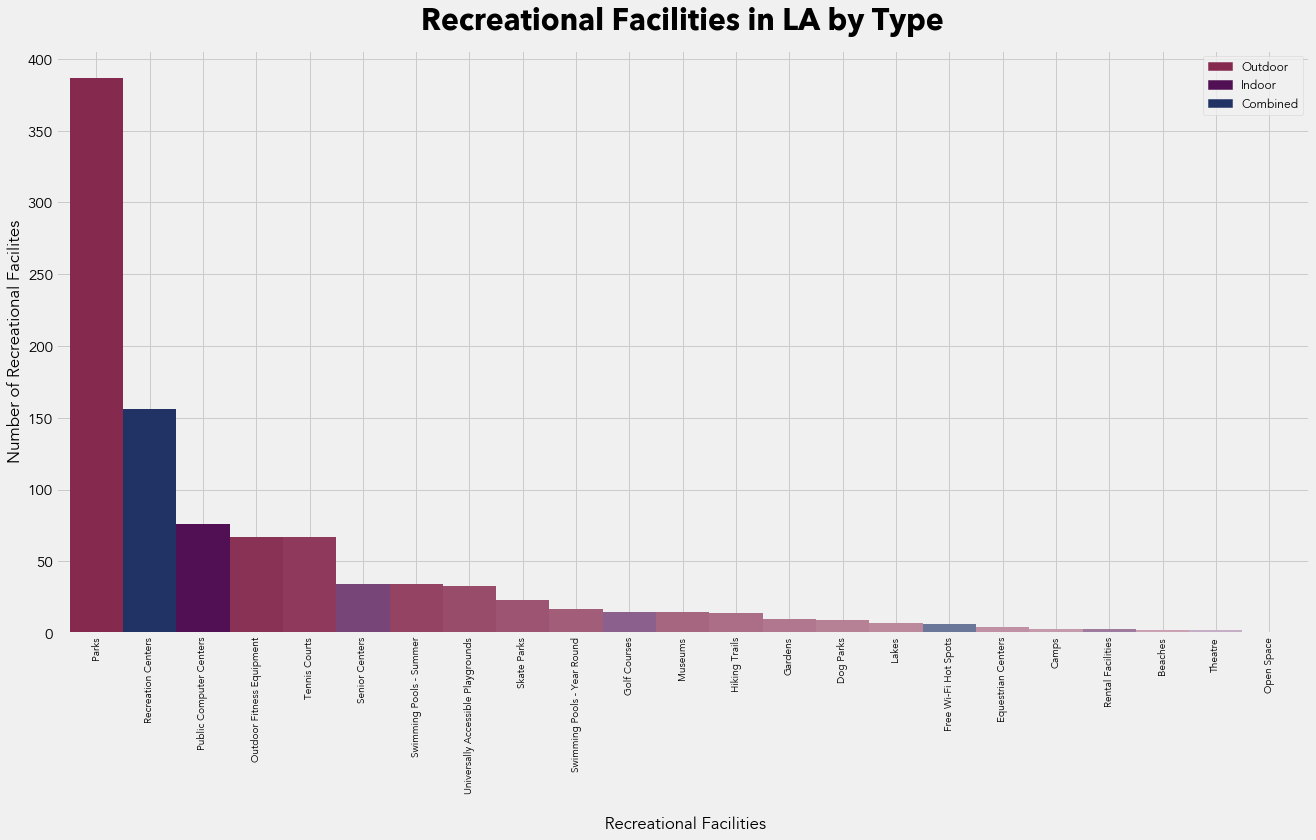

In [9]:
Location_types()

**Parks and recreation centers have the highest occurence, possibly linked to these facilities are often multi-use spaces.**

### Alternative Representations
The previous bar chart clearly demonstrated the rankings of the facility's occurence but I wanted to visualise the proportions of each type of facility in a clearer method than a pie chart. The tree plots also incorporated categories into the plots.

In [10]:
sum_column = dfcategory.sum(axis=0)
print (sum_column)
def treeplot():
    squarify.plot(sizes=sum_column,
                  color=['#85294e','#511053','#213364'],
                  label=['Outdoor Facilities', 'Indoor Facilities', 'Combined Facilities'],
                  text_kwargs={'fontsize':20, 'color':'white','weight':'bold'})
    plt.title('Proportions of Facility Category',family="Avenir Next",pad=20,fontsize=30)
    plt.axis('off')
    plt.show()

Outdoor_Count     693.0
Indoor_Count      130.0
Combined_Count    162.0
dtype: float64


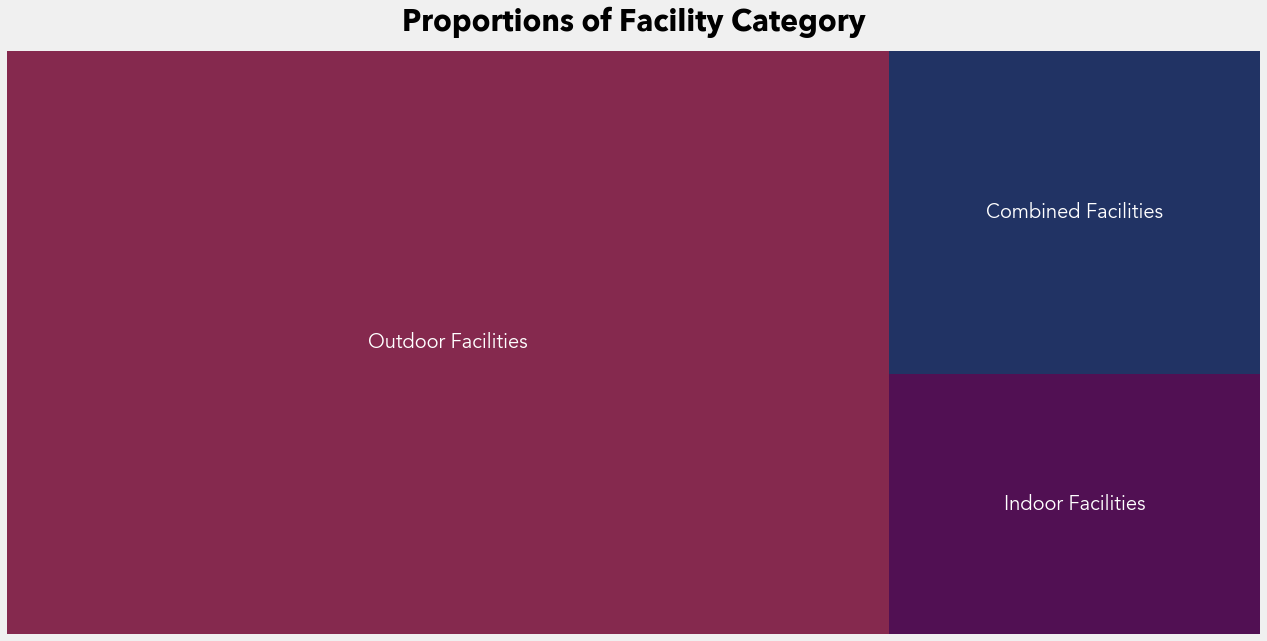

In [11]:
treeplot()

In [12]:
def treeplot2():
    dfrec_data["LocationType"].value_counts()

    squarify.plot(sizes=dfrec_data["LocationType"].value_counts(),
                  color=treeplotcolour,
                  label=labelsformat,
                  text_kwargs={'fontsize':12, 'color':'white','weight':'bold'}
                  ,pad=False)
    plt.title('Proportions of Facility Type',family="Avenir Next",pad=20,fontsize=30)
    plt.axis('off')
    plt.show()

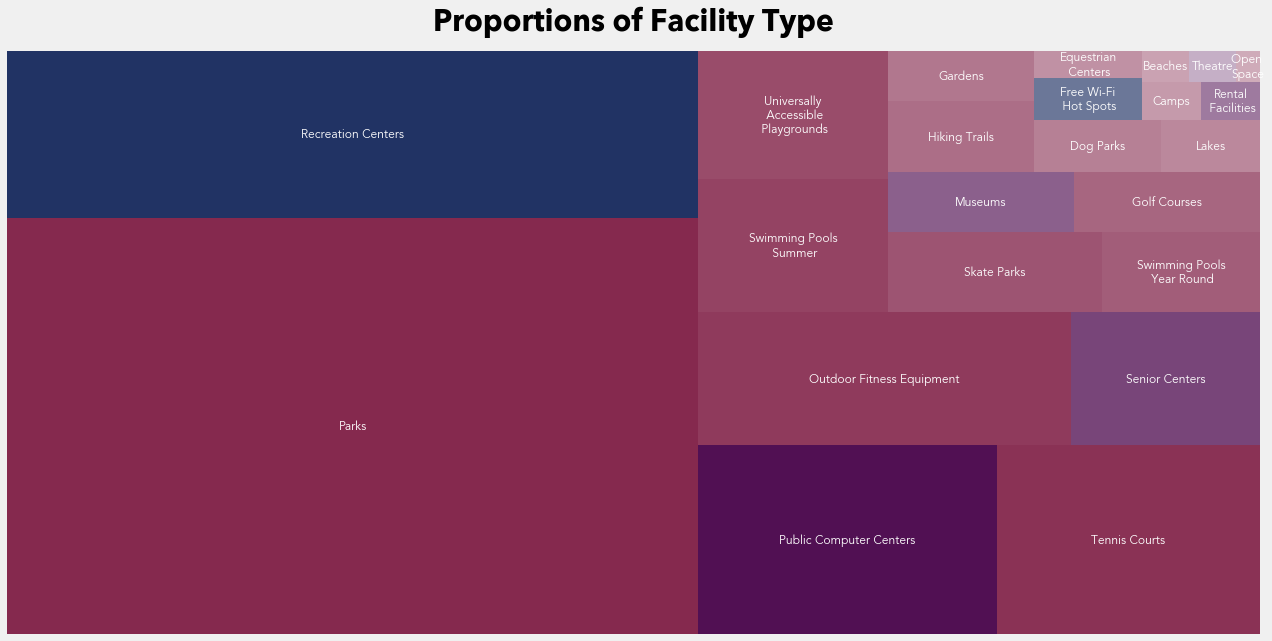

In [13]:
treeplot2()

In [14]:
def zipcodes_count():
    Zipcounts = dfrec_data["Zip"].value_counts()
    Zipcounts[Zipcounts < 5000].plot(kind="bar", color=['#96A5CB'], edgecolor='white')

    plt.yticks()
    plt.xticks(fontsize=10, rotation='90')
    plt.title("Number of Recreational Facilities per Zip Code",family="Avenir Next",pad=20,fontsize=30)
    plt.xlabel('\n Zip Codes')
    plt.ylabel('Number of Recreational Facilities', rotation='vertical')
    plt.show()

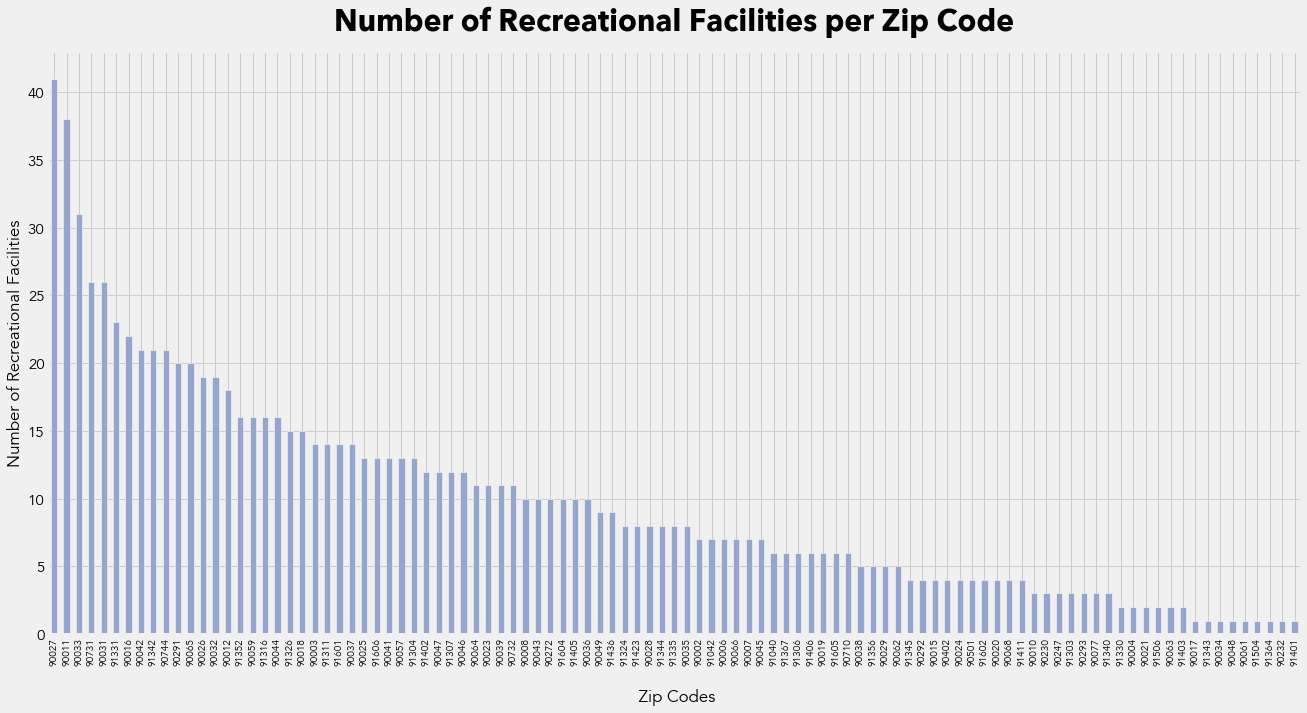

In [15]:
zipcodes_count()

In [16]:
def facilities_count():
    Zipcounts = dfrec_data["Zip"].value_counts()
    Zipcounts[Zipcounts < 5000].plot(kind="hist", bins=15, color=['#96A5CB'], edgecolor='white')

    plt.yticks(fontsize=10)
    plt.xticks(fontsize=10)
    plt.title("Number of Recreational Facilities per Zip Code",family="Avenir Next",pad=20,fontsize=30)
    plt.xlabel('\n Number of Recreational Facilities')
    plt.ylabel('Number of Zip Codes', rotation='vertical')
    plt.grid(True)
    #90027 has the highest number of rec facilities, it is a park containing zoos, trails and other things
    return plt.show()

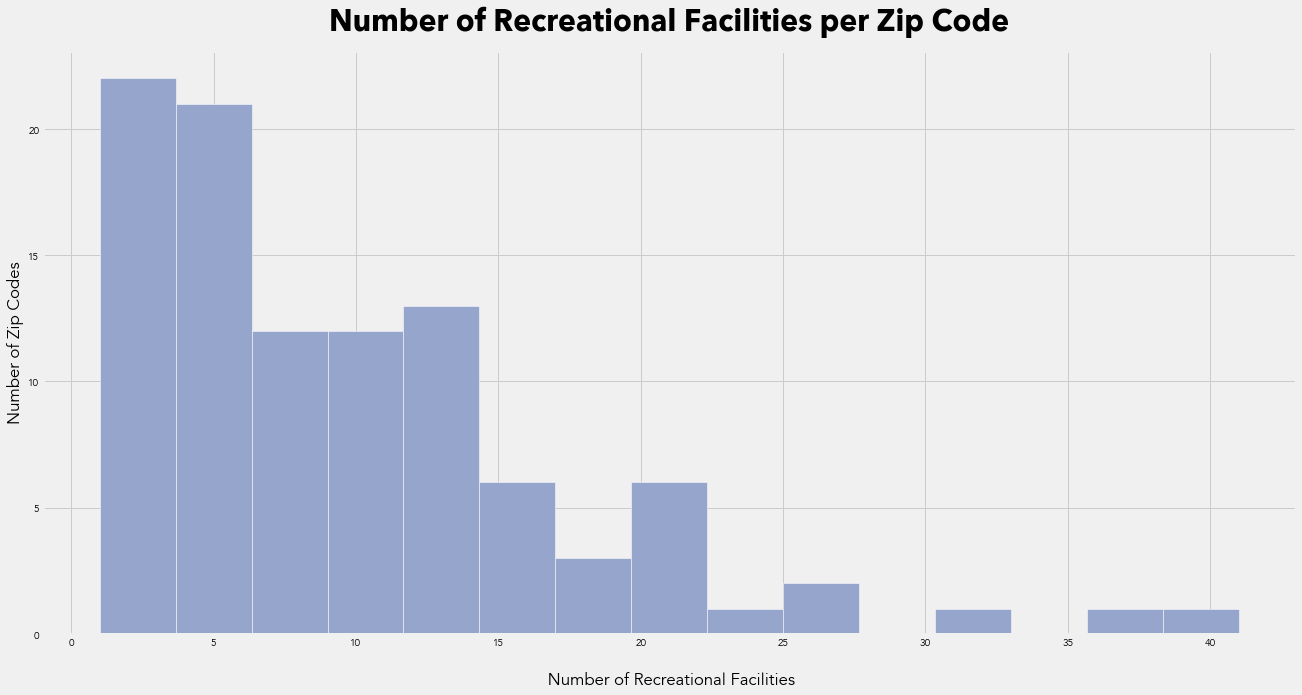

In [17]:
facilities_count()

**Between 1-6 facilities per zip code is the most common**

**Los Feliz (90027) has the highest number of recreational facilities. Further research indicates that it is the largest green area in LA, contains large parks, zoos and trails.**

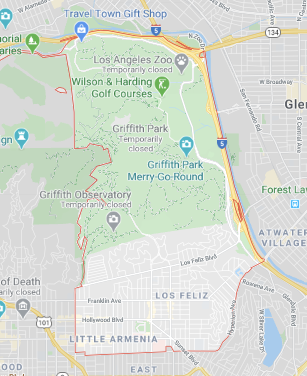
Sourced from Google Maps

In [18]:
def stacked():
    #.loc[:, is used to maintain a specific order
    dfmerged_data2.loc[:,['Parks','Tennis Courts','Outdoor Fitness Equipment','Swimming Pools - Summer',
         'Universally Accessible Playgrounds','Skate Parks','Swimming Pools - Year Round','Golf Courses',
         'Hiking Trails','Gardens','Dog Parks','Lakes','Equestrian Centers','Camps','Beaches','Open Space',
         'Public Computer Centers','Senior Centers','Museums','Rental Facilities','Theatre',
         'Recreation Centers','Free Wi-Fi Hot Spots']].plot.bar(stacked=True,color=stackedcolour).legend(bbox_to_anchor=(1, 1))
    
    
    plt.xticks(fontsize=10, rotation='90')
    plt.title("Breakdown of Facility Type Per Zip Code",family="Avenir Next",pad=20,fontsize=30)
    plt.xlabel('\n Zip Codes')
    plt.ylabel('Number of Recreational Facilities', rotation='vertical')
    plt.legend(frameon=False, loc=(1.01,0.1))
    plt.show()


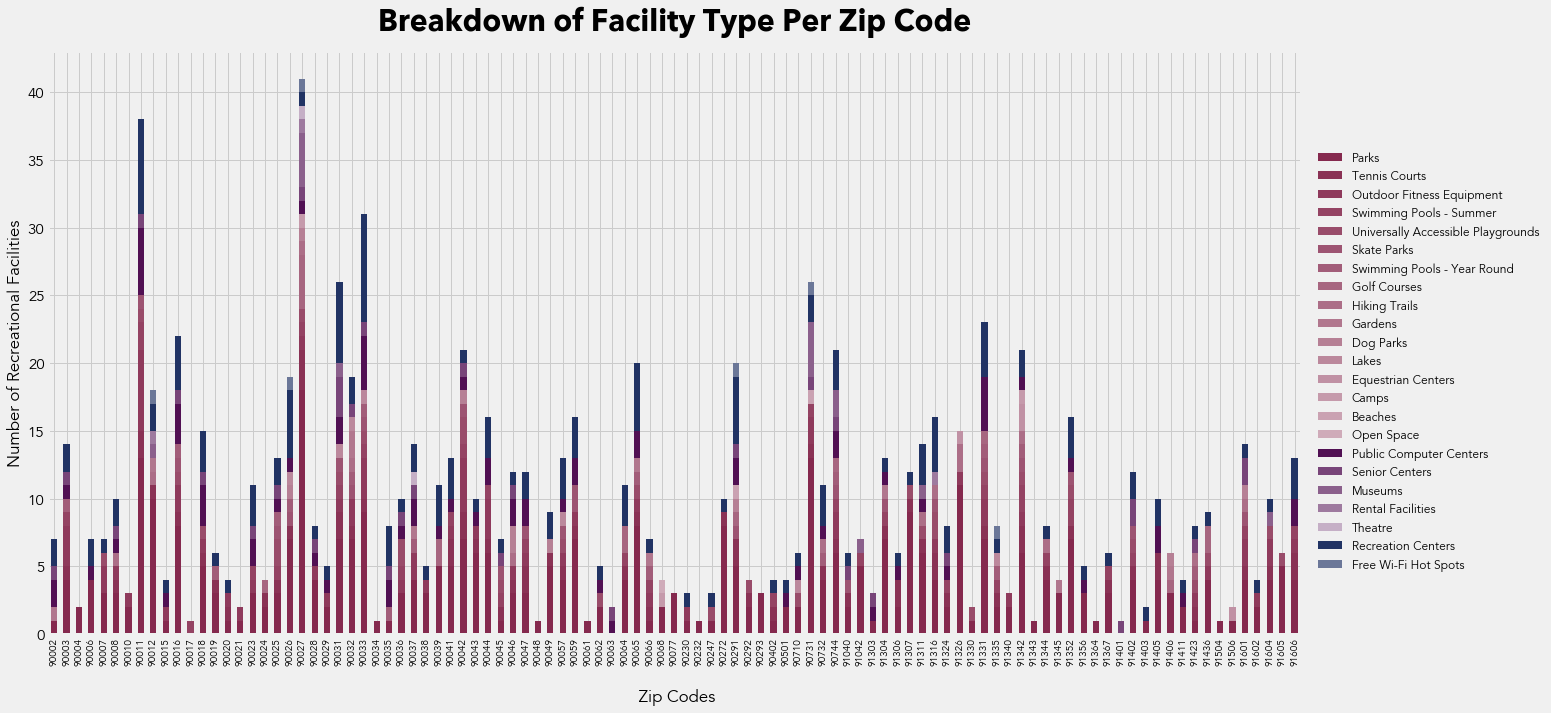

In [19]:
stacked()

In [20]:
def council_count():
    council = dfrec_data["CouncilDistrict"].value_counts()
    council[council > 5].plot(kind="bar", color=['#96A5CB'], edgecolor='white') #>5 was used to eliminate an outlier

    plt.xticks(rotation=0)
    plt.title("Number of Recreational Facilities per Council District",family="Avenir Next",pad=20,fontsize=30)
    plt.xlabel('\n Council Districts')
    plt.ylabel('Number of Recreational Facilities', rotation='vertical')
    plt.show()

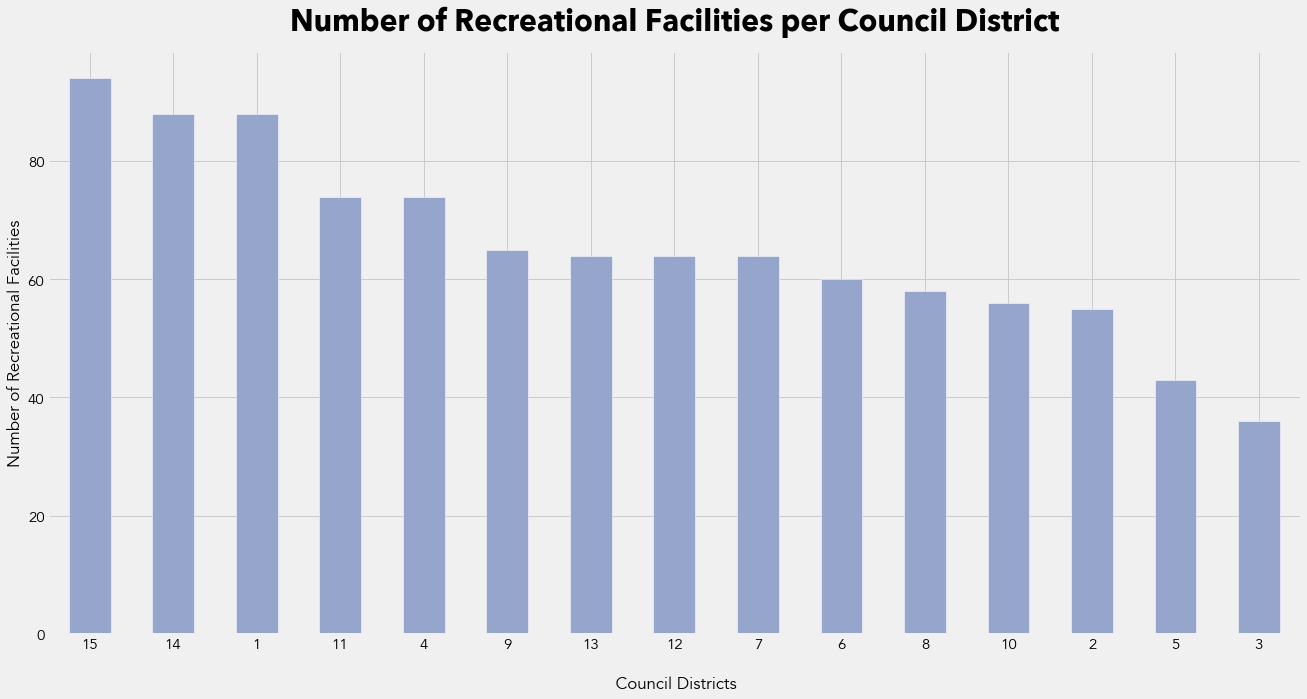

In [21]:
council_count()

**There is no singular council district that has a signficantly higher facilities count demonstrating that this is not a determining factor.**

In [22]:
def pop_correlation():
    plt.rc('xtick', labelsize=10) #global settings needed as the xtick for this specific graph could not be changed manually
    df = pd.DataFrame({'Count': dfmerged_data["Total_Count"] , 'Pop':dfmerged_data["Population"], 'Zip':dfmerged_data["Zip"] })

    fig,ax1 = plt.subplots()
    ax2 = ax1.twinx()

    df.plot(x= 'Zip', y= 'Count',kind='bar', color='#AEBFD9', ax=ax1)
    df['Pop'].plot(x = 'Zip', y='Pop',kind='line', marker='o', color='#8770AF',linewidth=2, ax=ax2)
    ax1.yaxis.tick_right()
    ax2.yaxis.tick_left()
    ax1.set_ylabel('Total Population', labelpad = 50)
    ax2.set_ylabel('Recreational Facilities Count', labelpad = 30)
    ax1.set_xlabel('Zip Code',labelpad = 10)
    plt.title("Correlation Between the Number of Recreational Facilities and Total Population Per Zip Code"
              ,family="Avenir Next",pad=20,fontsize=30)
    ax1.get_legend().remove()
    
    
    bar = mpatches.Patch(color='#AEBFD9', label='Count')
    line = mpatches.Patch(color='#8770AF', label='Population')
    plt.legend(handles=[bar,line])
    return plt.show()

I wanted to look into incorporating the census date into the analysis to determine if more meaningful trends could be drawn from the data. This first graph expanded on the original zip bar chart to determine a correlation.

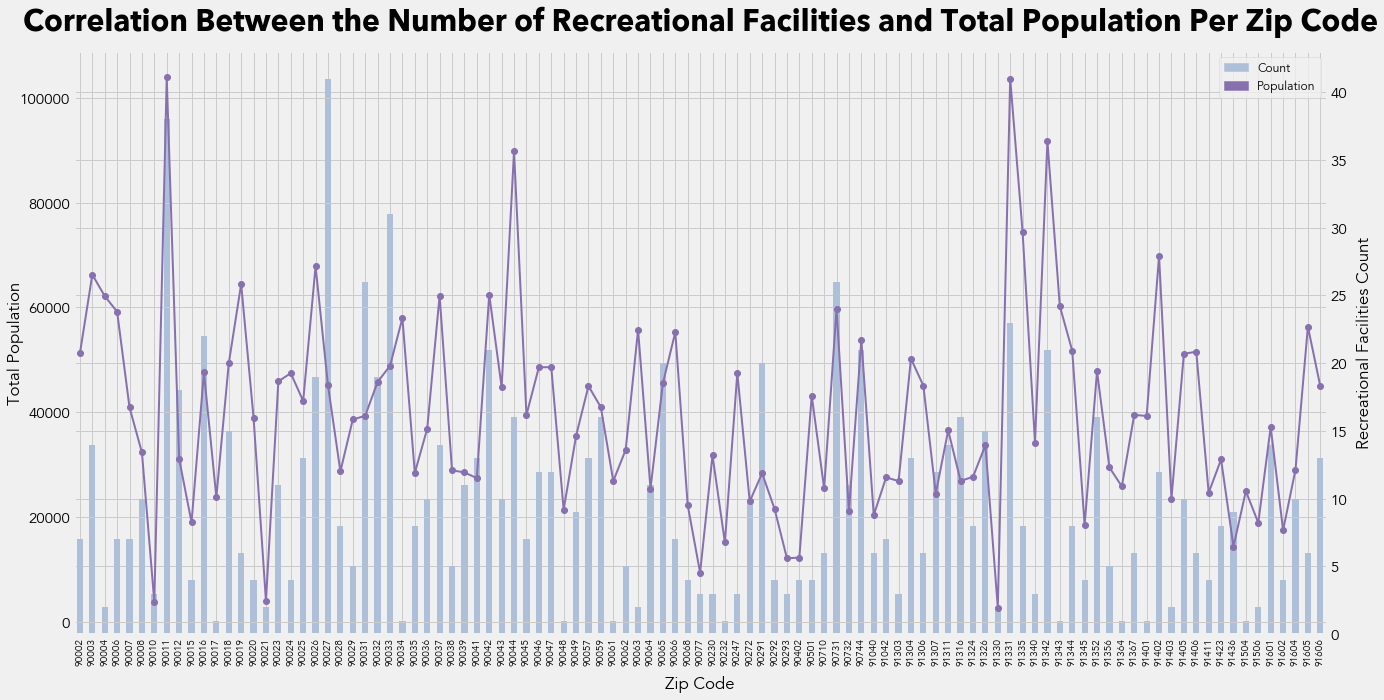

In [23]:
pop_correlation()

**There appears to be a slight correlation between population and the number of facilities**

# Question One: Are the types and number of recreational facilities within a zip code related to its demographic?
### Hypothesis: Yes

Demographic options available to investigate: total population, median age, total males, total females, total househoulds, average household size.

Scatter graphs were chosen to visualise correlation.

In [24]:
#scatter data frame shortcuts
dfscatter = pd.DataFrame({'Count': dfmerged_data["Total_Count"] , 'Age':dfmerged_data["MedianAge"], 'Zip':dfmerged_data["Zip"] ,'Pop':dfmerged_data["Population"],'House':dfmerged_data["Households"], 'Size':dfmerged_data["AvgHouseholdSize"]})
plt.rc('xtick', labelsize=15)

In [25]:
def pop_scatter():
    plt.scatter(x= dfscatter.Pop, y= dfscatter.Count, s=dfscatter.Count*7, color='#7D5F9E', alpha =0.5)
    plt.title("Correlation Between Number of Recreational Facilities and Population Per Zip Code"
              ,family="Avenir Next",pad=20,fontsize=30)
    plt.xlabel('Population', labelpad = 30)
    plt.ylabel('Recreational Facilities Count', labelpad = 20)
    return plt.show()

def age_scatter():
    plt.scatter(x= dfscatter.Age, y= dfscatter.Count, s=dfscatter.Count*7, color='#7D5F9E', alpha =0.5)
    plt.xlabel('Median Age', labelpad = 30)
    plt.ylabel('Recreational Facilities Count', labelpad = 20)
    plt.title("Correlation Between Number of Recreational Facilities and Median Age Per Zip Code"
              ,family="Avenir Next",pad=20,fontsize=30)
    return plt.show()

def house_scatter():
    plt.scatter(x= dfscatter.House, y= dfscatter.Count, s=dfscatter.Count*7, color='#7D5F9E', alpha =0.5)
    plt.title("Correlation Between Number of Recreational Facilities and Number of Households",
              family="Avenir Next",pad=20,fontsize=30)
    plt.xlabel('Number of Households', labelpad = 30)
    plt.ylabel('Recreational Facilities Count', labelpad = 20)
    return plt.show()

def size_scatter():
    plt.scatter(x= dfscatter.Size, y= dfscatter.Count, s=dfscatter.Count*7, color='#7D5F9E', alpha =0.5)
    plt.title("Correlation Between Number of Recreational Facilities and Average Household Size"
              ,family="Avenir Next",pad=20,fontsize=30)
    plt.xlabel('Average Household Size', labelpad = 30)
    plt.ylabel('Recreational Facilities Count', labelpad = 20)
    return plt.show()

The size of the markers are related to the recreational facility count.

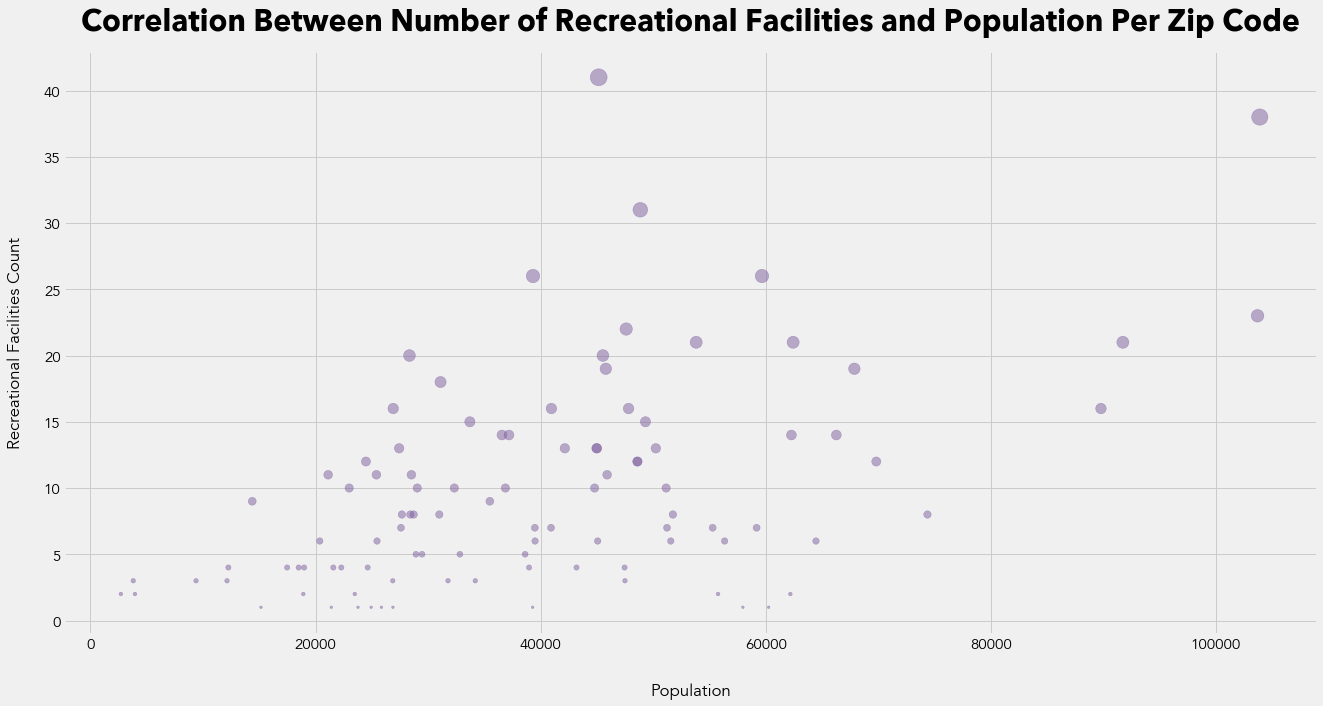

In [26]:
pop_scatter()

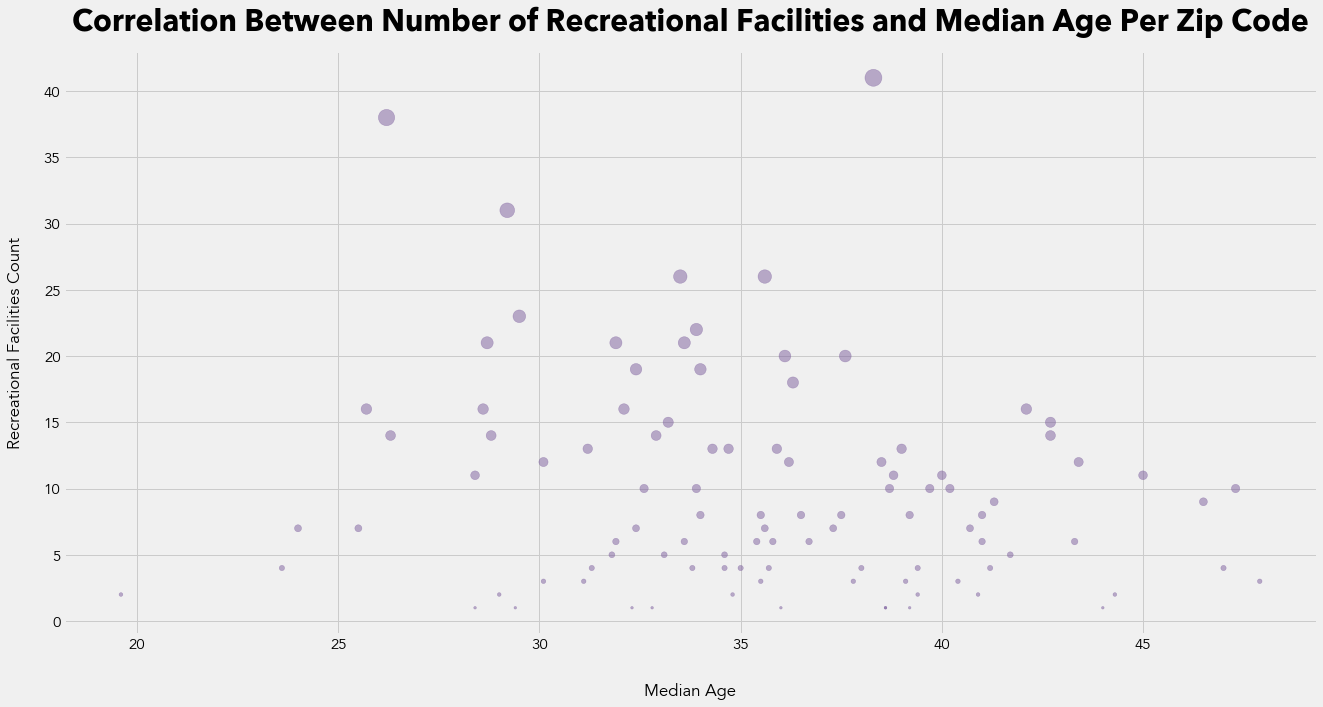

In [27]:
age_scatter()

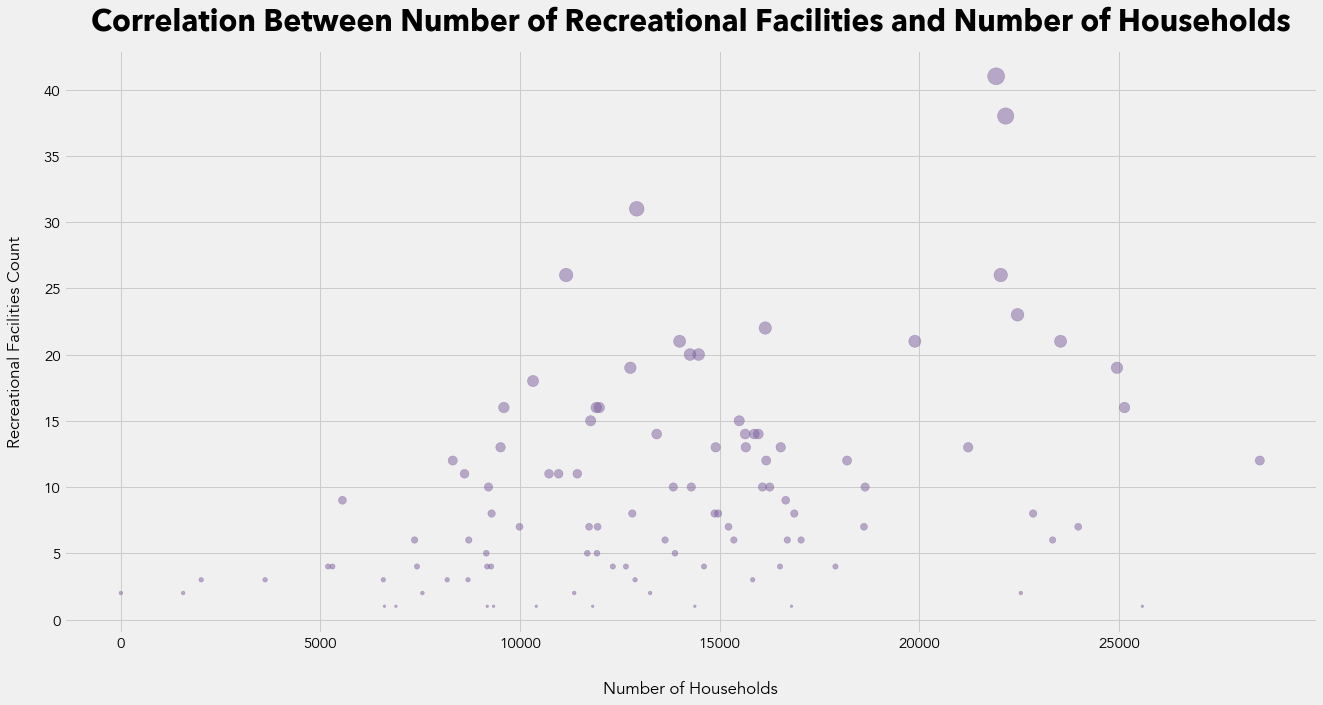

In [28]:
house_scatter()

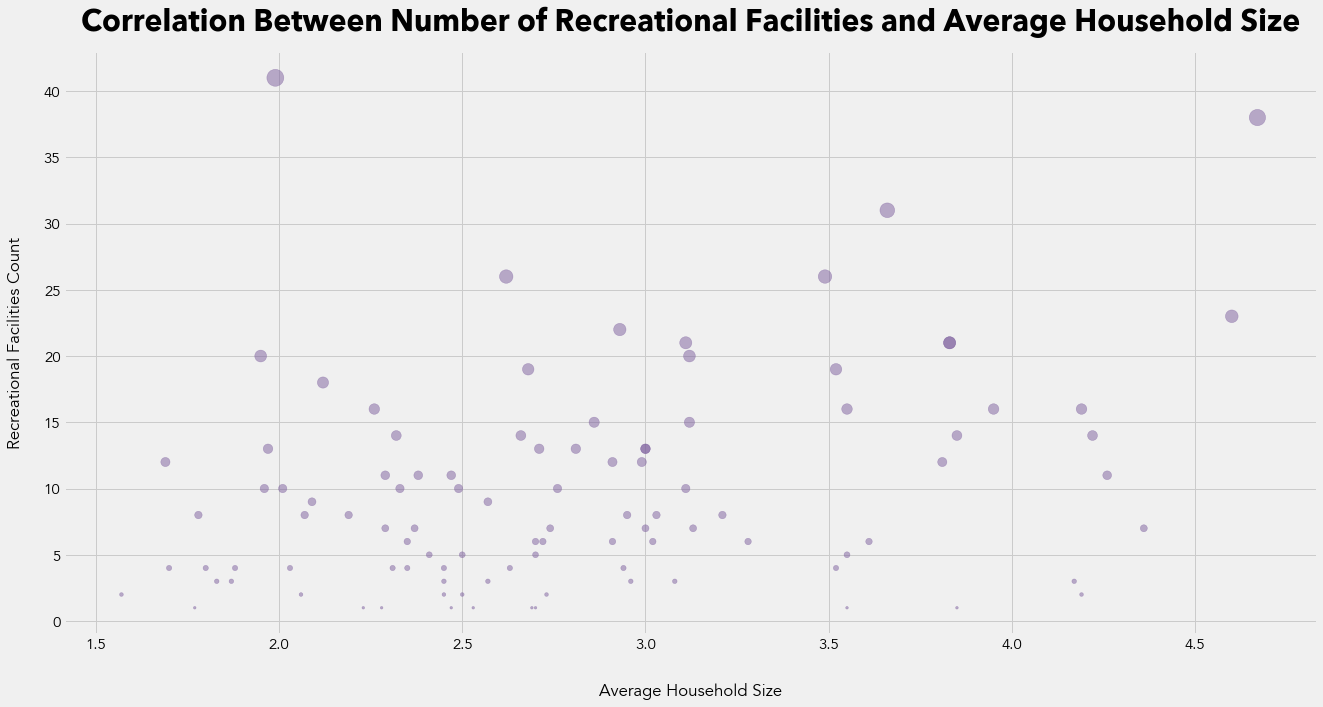

In [29]:
size_scatter()

**The above plots indicate a slight correlation between facilities count and population or average household size.** This is logical as a larger population would be linked to an increased number of households.

Median age and average household size does not indicate correlation. This was interesting as I assumes that families (larger household size) would live in areas with a higher number facilities. However, the distribution of median age is centered towards the center (35 years old) so this would not be suitable to determine a correlation.



Based on the assumption that the median age may be related to facility types, **further plots looked into correlations between median age and playgrounds, senior centers, skate parks or overall recreational centers.**

In [30]:
def playground():
    plt.scatter(x= dfmerged_data["MedianAge"], y= dfmerged_data["Universally Accessible Playgrounds"], color='#511053', s=dfscatter.Count*7, alpha =0.5)
    plt.title("Correlation Between Number of Universally Accessible Playgrounds and Median Age",
              family="Avenir Next",pad=20,fontsize=30)
    plt.yticks(np.arange(0, 4, step=1))
    plt.xlabel('Median Age', labelpad = 30)
    plt.ylabel('Universally Accessible Playgrounds Count', labelpad = 20)
    plt.show()

def senior():    
    plt.scatter(x= dfmerged_data["MedianAge"], y= dfmerged_data["Senior Centers"],color='#511053', s=dfscatter.Count*7, alpha =0.55)
    plt.title("Correlation Between Number of Senior Centres and Median Age",
              family="Avenir Next",pad=20,fontsize=30)
    plt.yticks(np.arange(0, 4, step=1))
    plt.xlabel('Median Age', labelpad = 30)
    plt.ylabel('Senior Centres Count', labelpad = 20)
    plt.show()


def skate():
    plt.scatter(x= dfmerged_data["MedianAge"], y= dfmerged_data["Skate Parks"],color='#511053', s=dfscatter.Count*7, alpha =0.55)
    plt.title("Correlation Between Number of Skate Parks and Median Age"
              ,family="Avenir Next",pad=20,fontsize=30)
    plt.yticks(np.arange(0, 4, step=1))
    plt.xlabel('Median Age', labelpad = 30)
    plt.ylabel('Skate Parks', labelpad = 20)
    plt.show()

def rectotal():
    plt.scatter(x= dfmerged_data["MedianAge"], y= dfmerged_data["Recreation Centers"],color='#511053', s=dfscatter.Count*7, alpha =0.5)
    plt.title("Correlation Between Number of Recreational Centers and Median Age",
              family="Avenir Next",pad=20,fontsize=30)
    plt.xlabel('Median Age', labelpad = 30)
    plt.ylabel('Recreational Centers Count', labelpad = 20)
    plt.show()

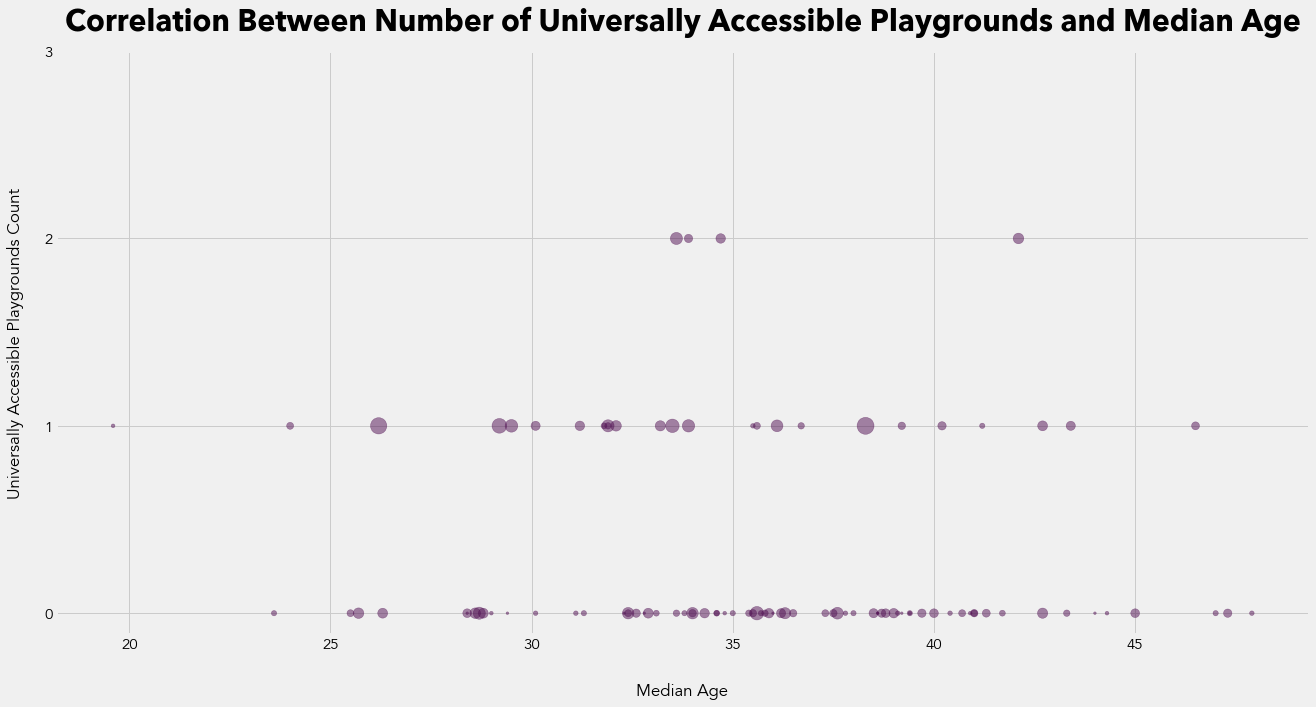

In [31]:
playground()

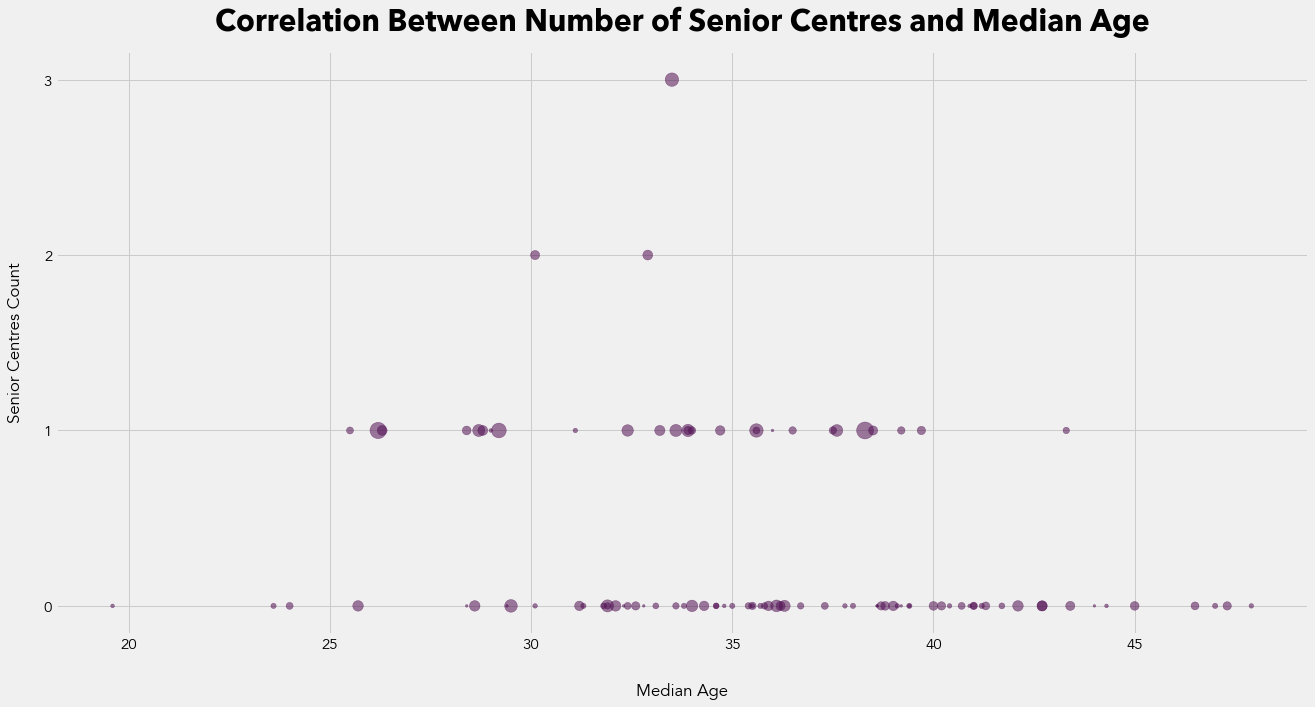

In [32]:
senior()

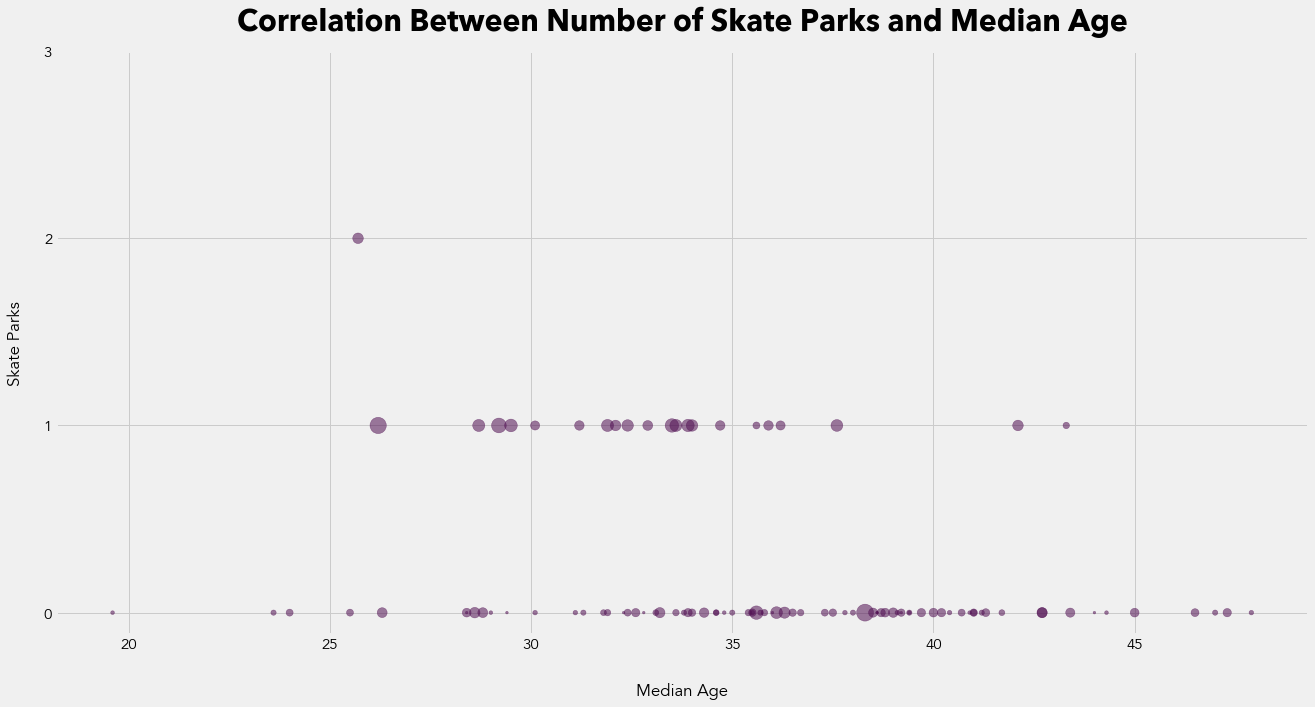

In [33]:
skate()

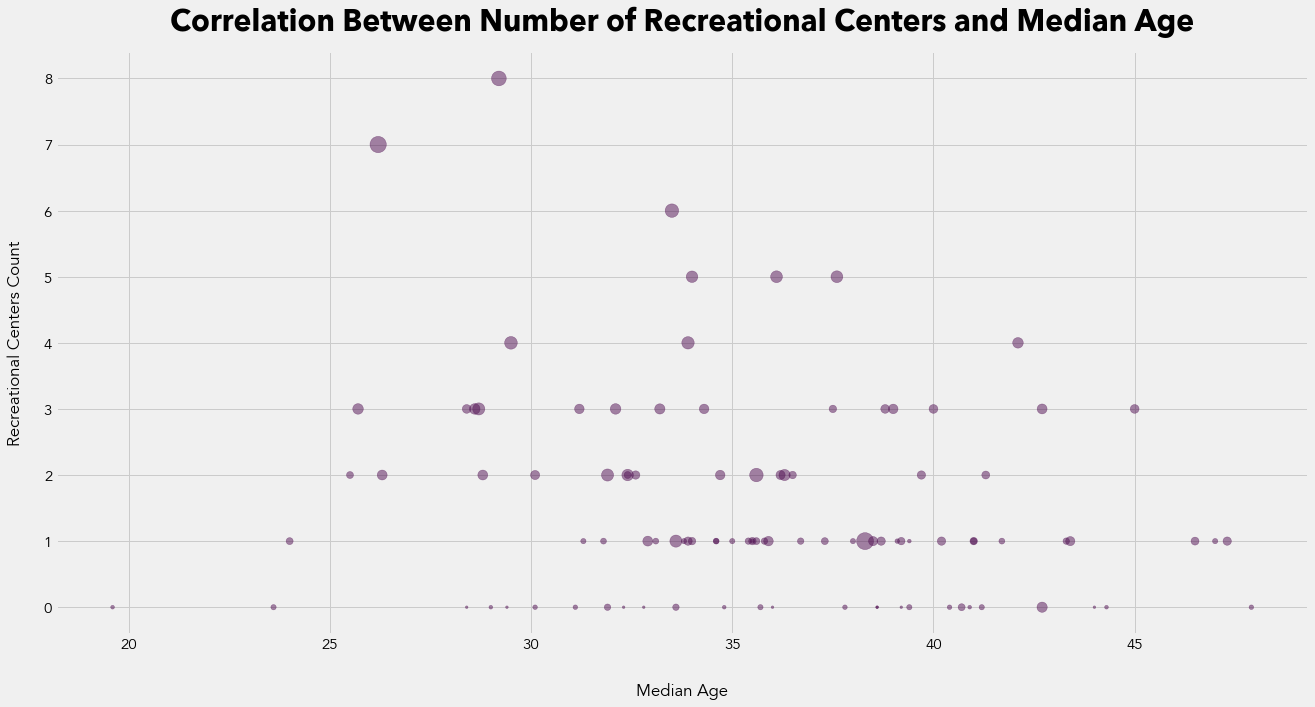

In [34]:
rectotal()

**These plots further show little to no correlation between median age and facility type.**

I chose to leave the zip codes with zero counts of the facilities in the scatter plot as it also helped to visualise the number of zip codes that do not have certain facilities available.

# Question One: Are the types and number of recreational facilities within a zip code related to its demographic?
### Hypothesis: Yes
### Findings: No

# Maps

I wanted to visualise the location of each parks by plotting their locations on a map of LA. I found the following shape files to form my maps: 

California: https://data.ca.gov/dataset/ca-geographic-boundaries

LA county: https://hub.arcgis.com/datasets/lacounty::la-county-city-boundaries

LA Zip codes: http://geohub.lacity.org/datasets/los-angeles-city-zip-codes

The below code downloads the data and adds the centroid and facility counts to the table.

In [35]:
park_points = gp.GeoDataFrame(dfrec_data, geometry=gp.points_from_xy(dfrec_data.GeoLong, dfrec_data.GeoLat))
#park_points.plot()

county = gp.GeoDataFrame.from_file("LA_County_Boundaries-shp/LA_County_City_Boundaries.shp")
#county.head(2)
#county.plot90

cali=gp.GeoDataFrame.from_file("CA_Counties/CA_Counties_TIGER2016.shp")

zipgeo = gp.GeoDataFrame.from_file("Los_Angeles_City_Zip_Codes-shp/b982f3c3-ffe6-4e4a-b8e6-2bd1eb2c70642020328-1-26h3sc.00ox.shp")
#zipgeo.head(2)
#zip.plot()

#adding centroid
def add_centroid(row):
    return row.geometry.centroid

zipgeo["centroid"] = zipgeo.apply(add_centroid, axis=1)
zipgeo=zipgeo.rename(columns=({'ZIPCODE':'Zip'}))
zipgeo.set_index('ZIP',inplace=True)

#adding facility count
counts=dfrec_data["Zip"].value_counts()
reccounts = pd.DataFrame(counts)
reccounts=reccounts.rename(columns=({'Zip':'Total_Count'}))
#print(reccounts)
zipgeo.insert(5, "Facility Count",reccounts,True)

zipgeo["Outdoor_Count"]=dfcategory["Outdoor_Count"]
zipgeo["Indoor_Count"]=dfcategory["Indoor_Count"]
zipgeo["Combined_Count"]=dfcategory["Combined_Count"]

#cali.head(6)

**Contextualisation of the City of LA** 

To provide come context for the LA city location, the map of California is used to locate the LA county area followed by overlaying the LA city on the LA county map. The shape file location properties where not consistent over the cali and county files thus they could not be overlayed. 

In [36]:
def context():
    ax = cali.plot(figsize=(8,8), edgecolor='white', color='lightgrey')
    ax.axis('off')
    
    # needed to research to find out how to colour only one area, the below code 
    # is adapted from a world map country identification code
    
    findLA = cali[cali.NAMELSAD == 'Los Angeles County']
    findLAgm = findLA.__geo_interface__['features']  
    findLAg0 = {'type': findLAgm[0]['geometry']['type'], \
            'coordinates': findLAgm[0]['geometry']['coordinates']}
    ax.add_patch(PolygonPatch(findLAg0, fc='#939BC6', ec="white", alpha=0.85, zorder=2 ))

    plt.title("Context",family="Avenir Next",fontsize=30)

    ref1 = mpatches.Patch(color='#939BC6', label='LA County')
    ref2 = mpatches.Patch(color='lightgrey', label='California')                        
    plt.legend(handles=[ref1,ref2],loc=(0.8,0.88), frameon=False)

    return plt.show()

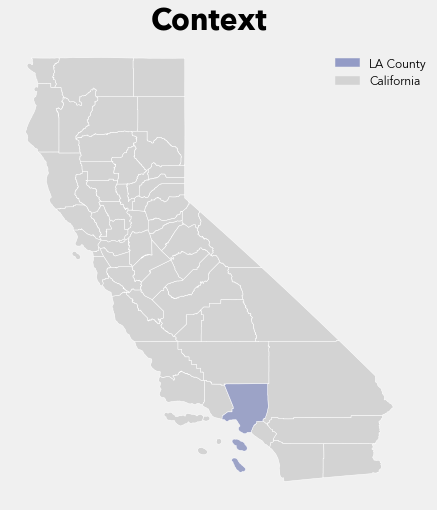

In [37]:
context()

In [38]:
def Map_County():
    fig, ax = plt.subplots()
    ax.set_aspect('equal')

    county.plot(ax=ax, color = "#939BC6",edgecolor='#7480c4',)
    zipgeo.plot(ax=ax, color = "#B8CADF",edgecolor='#B8CADF')
    park_points.plot(ax=ax, color='#8875B2', marker=".", markersize=5,alpha=0.5)
    plt.axis('off')
    
    ref1 = mpatches.Patch(color='#939BC6', label='LA County')
    ref2 = mpatches.Patch(color='#B8CADF', label='LA City')
    ref3 = Line2D([0], [0], marker='.', color='#f0f0f0', label='Parks', markerfacecolor='#8875B2', markersize=20)               
                        
    plt.legend(handles=[ref1,ref2,ref3],loc=(1,0.8), frameon=False)

    plt.title("The City of LA Recreational Centre \n Locations in LA County",family="Avenir Next",fontsize=30)
    return plt.show()


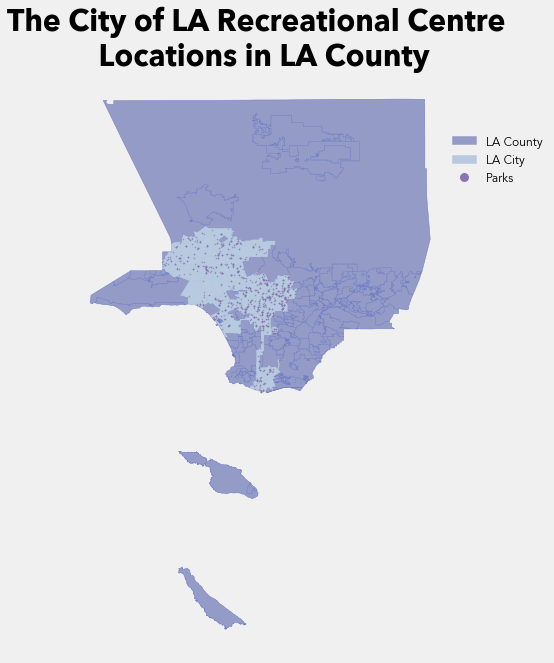

In [39]:
Map_County()

**There is a higher density of parks in the eastern side of the city.**

Beverly Hills and the Hollywood area is more towards the western side of the map, thus having less recreational areas would make sense as it is a more commerical area.

The next map is just focussing on soley the LA city area with the plot points. 

In [40]:
def Map_City():   
    fig, ax = plt.subplots()
    ax.set_aspect('equal')

    zipgeo.plot(ax=ax, color = "#B8CADF",edgecolor='white')
    park_points.plot(ax=ax, color='#8875B2', marker=".", markersize=45,alpha=0.5)

    plt.title("Recreational Centres in the City of LA",family="Avenir Next",fontsize=30)
    plt.axis('off')              
                    
    ref1 = mpatches.Patch(color='#B8CADF', label='LA City')
    ref2 = Line2D([0], [0], marker='.', color='#f0f0f0', label='Parks', markerfacecolor='#8875B2', markersize=20)    
    plt.legend(handles=[ref1,ref2],loc=(0.85,0.9), frameon=False)
    
    #zip labels can be turned on if needed, but some of the smaller zip codes leads to messy labelling
    
    #for idx, row in zipgeo.iterrows():
    #    plt.annotate(s=row.Zip, xy=tuple(row.centroid.coords)[0], xycoords="data",horizontalalignment='center',fontsize=5)
     
    
    return plt.show()

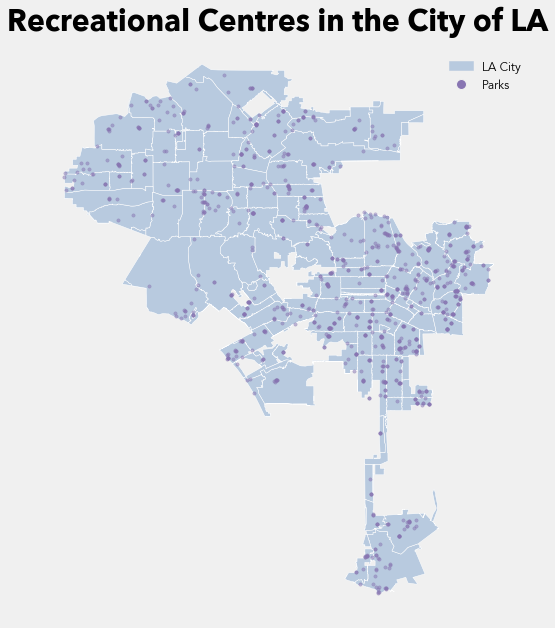

In [41]:
Map_City()

The below choropleth map is an alternative representation of the above scatter plot map demonstrating the the number of facilities per zip code using a colour gradient. The darker grey tone was used in the zip codes that had no data available.

In [42]:
def choropleth():
    fig,ax=plt.subplots()
    ax.set_aspect('equal')

    zipgeo.plot(ax=ax, color = "lightgrey",edgecolor='#B8CADF')
    zipgeo.plot(ax=ax, column="Facility Count", cmap='BuPu', legend=True,edgecolor='#B8CADF')
    ax.set_title("Number of Recreational Facilities\n In LA Zip Codes",pad=10
                 ,family="Avenir Next",fontsize=30)
    
    plt.text(1.2, 1.02, 'COUNT', horizontalalignment='center', verticalalignment='center', 
             transform=ax.transAxes, fontsize=10, family='avenir next')  
    
    plt.axis('off')
    plt.show()    
    

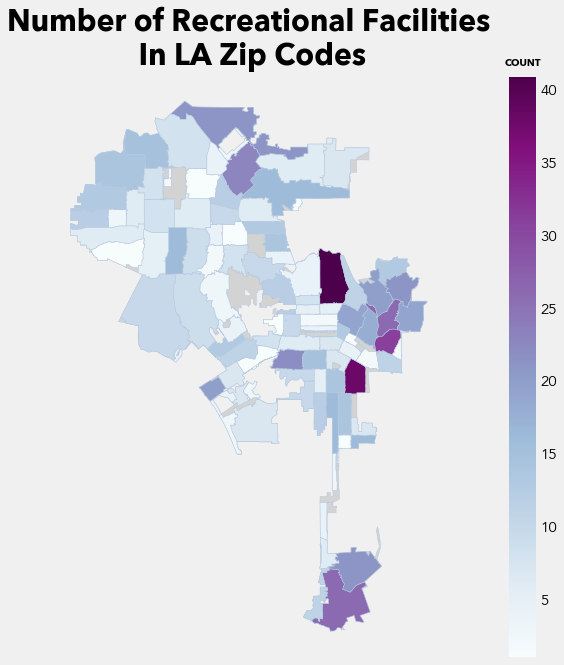

In [43]:
choropleth()

In [44]:
def bubble1():
    zipgeo_points = zipgeo.copy()
    zipgeo_points['geometry'] = zipgeo_points['centroid']

    fig, ax = plt.subplots()
    zipgeo.plot(ax=ax,color = "#B8CADF",edgecolor='white')
    zipgeo_points.plot(ax=ax,color='#8875B2', markersize=zipgeo['Facility Count']*35, alpha = 0.5, 
                       categorical=False)
    zipgeo_points.plot(ax=ax,color='white',markersize=3, categorical=False)

    ax.axis("off")
    ax.set_title("Total Number of Recreational \n Facilities In Each Zip Code",pad=10
                    ,family="Avenir Next",fontsize=30)

    plt.show()

In [45]:
def bubble2():
    zipgeo_points = zipgeo.copy()
    zipgeo_points['geometry'] = zipgeo_points['centroid']

    fig, ax = plt.subplots()
    zipgeo.plot(ax=ax,color = "#B8CADF",edgecolor='white')

    #totals
    #zipgeo_points.plot(ax=ax,color='#8875B2', markersize=zipgeo['Facility Count']*15, alpha = 0.5, categorical=False, legend=True)


    zipgeo_points.plot(ax=ax,color='#85294E', markersize=zipgeo['Outdoor_Count']*35, alpha = 0.4, edgecolor='w',
    linewidth=1,categorical=False, legend=True)
    zipgeo_points.plot(ax=ax,color='#511053', markersize=zipgeo['Indoor_Count']*35, alpha = 0.8, edgecolor='w', 
    linewidth=1,categorical=False, legend=True )
    zipgeo_points.plot(ax=ax,color='#213364', markersize=zipgeo['Combined_Count']*35,alpha = 0.6, edgecolor='w',
     linewidth=1,categorical=False, legend=True )
    
    ref1 = Line2D([0], [0], marker='.', color='#f0f0f0', label='Outdoor', markerfacecolor='#85294E', markersize=20,alpha=0.7)  
    ref2 = Line2D([0], [0], marker='.', color='#f0f0f0', label='Indoor', markerfacecolor='#511053', markersize=20,alpha=0.8) 
    ref3 = Line2D([0], [0], marker='.', color='#f0f0f0', label='Combined', markerfacecolor='#213364', markersize=20,alpha=0.8)     
    plt.legend(handles=[ref1,ref2,ref3],loc=(0.9,0.85), frameon=False)

    ax.axis("off")

    ax.set_title("Number of Recreational \n Facilities by Category",pad=10
                    ,family="Avenir Next",fontsize=30)

    plt.show()

The individual dots helped to visualise which areas were more dense with recreational facilities, another visualisation method is a bubble map where the size of the bubble is a representation of the number of facilities. I attempted to overlay bubble representing the number of outdoor, indoor and combined facilities. The opacity of each was manipulated so ensure that each colour was visible.

Note that the scale of the bubbles are consistent across both bubble maps. The white cross on the totals map represent the centroid of the zip code.

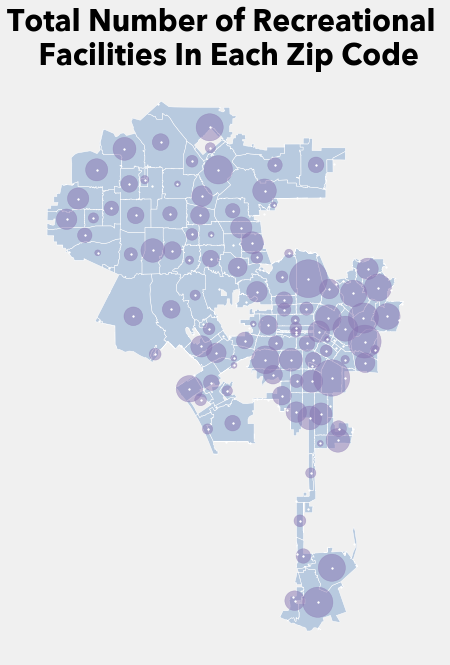

In [46]:
bubble1()

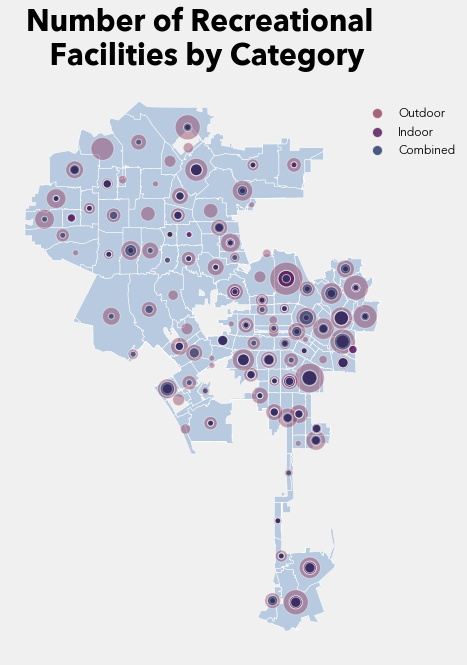

In [47]:
bubble2()

# Further Investigation
Through looking at the above graph, I wanted to investigate if there was any correlation between the zip code's land area and the number of facilities, i.e. density of facilities. To do this, I calculated the area using the given geometry details and normalised the facility count according to the area.

I also wanted to look into normalisation using population so I added the population column into zipgeo as well.

In [48]:
#calculating area
zipgeo["area"] = zipgeo.area*10**4 

#another method to calculate areainvolves the GeoSeries.to_crs() method, this was tested but when comparing the output
#to existing zip code land area details available online, it was inaccurate

#add population
population=dfmerged_data2["Population"]
pop = pd.DataFrame(population)
pop=pop.rename(columns=({'Zip':'Population'}))
#print(pop)
zipgeo.insert(5, "Population",pop,True)


#Normalizing with area
zipgeo["Facility per km2"]= (zipgeo['Facility Count']/zipgeo['area'])

#Normalizing with population
zipgeo["Facility per 10,000 people"]= (zipgeo['Facility Count']/(zipgeo['Population']/10000))


/Users/kachaoui17/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  


In [49]:
def choropleth2():
    fig,ax=plt.subplots()
    ax.set_aspect('equal')

    zipgeo.plot(ax=ax, color = "lightgrey",edgecolor='#B8CADF')
    zipgeo.plot(ax=ax, column="area", cmap='BuPu', legend=True,edgecolor='#B8CADF')
    ax.set_title("Land Area of LA Zip Codes ",family="Avenir Next",pad=35,fontsize=30,loc='right')
    
    plt.text(1.2, 1.02, 'AREA \n $km^{2}$', horizontalalignment='center', verticalalignment='center', 
             transform=ax.transAxes, fontsize=10, family='avenir next')    
    plt.axis('off')
    plt.show()

The below choropleth map uses the colour gradient to represent the land area size of each zip code.

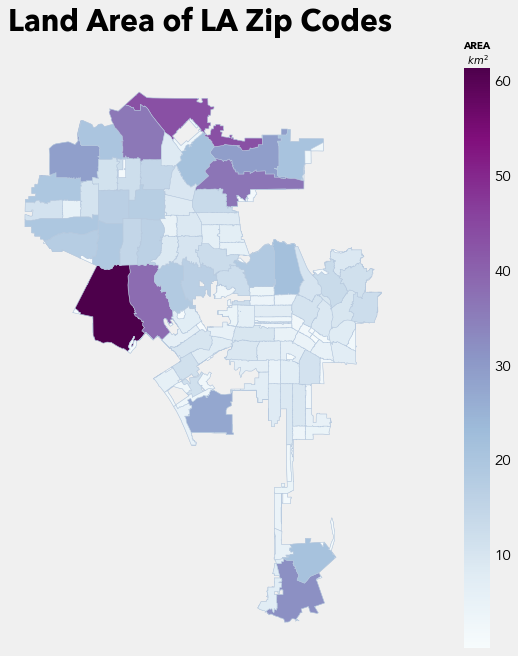

In [50]:
choropleth2()

# Question Two: Is the number of recreational facilities within a zip code related to its population or land area?
### Hypothesis: Yes


Further Scatter Plots and Histograms were created incorporating land area and population to normalize the data and draw conclusions 

In [51]:
def area():
    plt.scatter(x= zipgeo["area"], y= zipgeo["Facility Count"],color='#511053', s=dfscatter.Count*7, alpha =0.5)
    plt.title("Correlation Between Number of Recreational Centers and Zip Code Land Area",family="Avenir Next",pad=20,fontsize=30)
    plt.xlabel('Area in $km^{2}$', labelpad = 30)
    plt.ylabel('Recreational Facilities Count', labelpad = 20)
    plt.show()

#zipgeo["area"].idxmax()

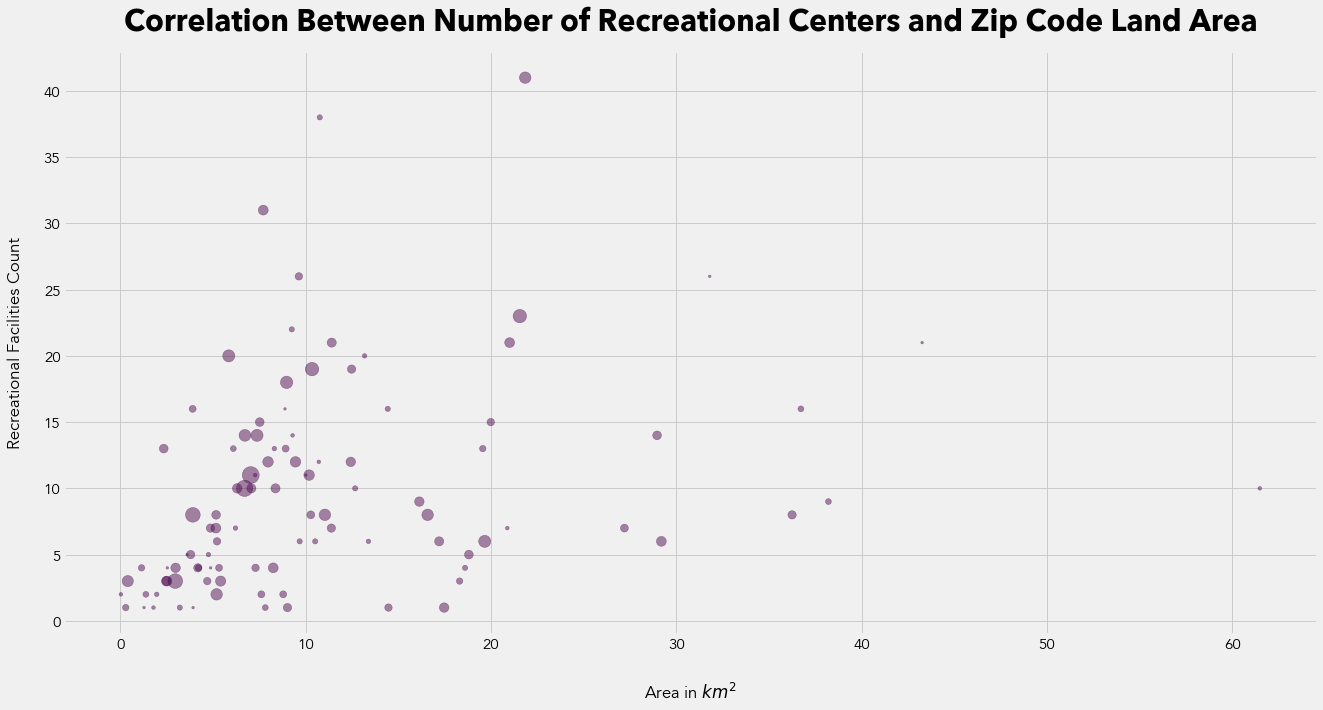

In [52]:
area()

**This plot shows a stronger correlation between area and facility count.**

There are some outliers such as Pacific Palisades (90272) which has an area over 60$km^{2}$ but a facility count of around 10. When researching further into this, this area contains a very large parks. Therefore, despite the parks occupying a larger propotion of the zip code's area, it results in a low count. 

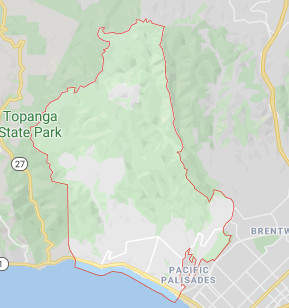 Sourced from Google Maps

In [53]:
def zipcodes_countnorm():
    countsnorm = zipgeo["Facility per km2"]
    countsnorm[countsnorm < 40].plot(kind="bar", color=['#96A5CB'], edgecolor='white') 
    #removed 91506 as the shape file does not contain the full boundaries of the zip code leading to 8 facilities per km2 which is not accurate

    plt.xticks(fontsize=10, rotation='90')
    plt.title("Recreational Facilities Density in each Zip Code",family="Avenir Next",pad=20,fontsize=30)
    plt.xlabel('\n Zip Codes')
    plt.ylabel('Number of Recreational Facilities per $km^{2}$', rotation='vertical',family="avenir")
    #90027 has the highest number of rec facilities, it is a park containing zoos, trails and other things
    plt.show()

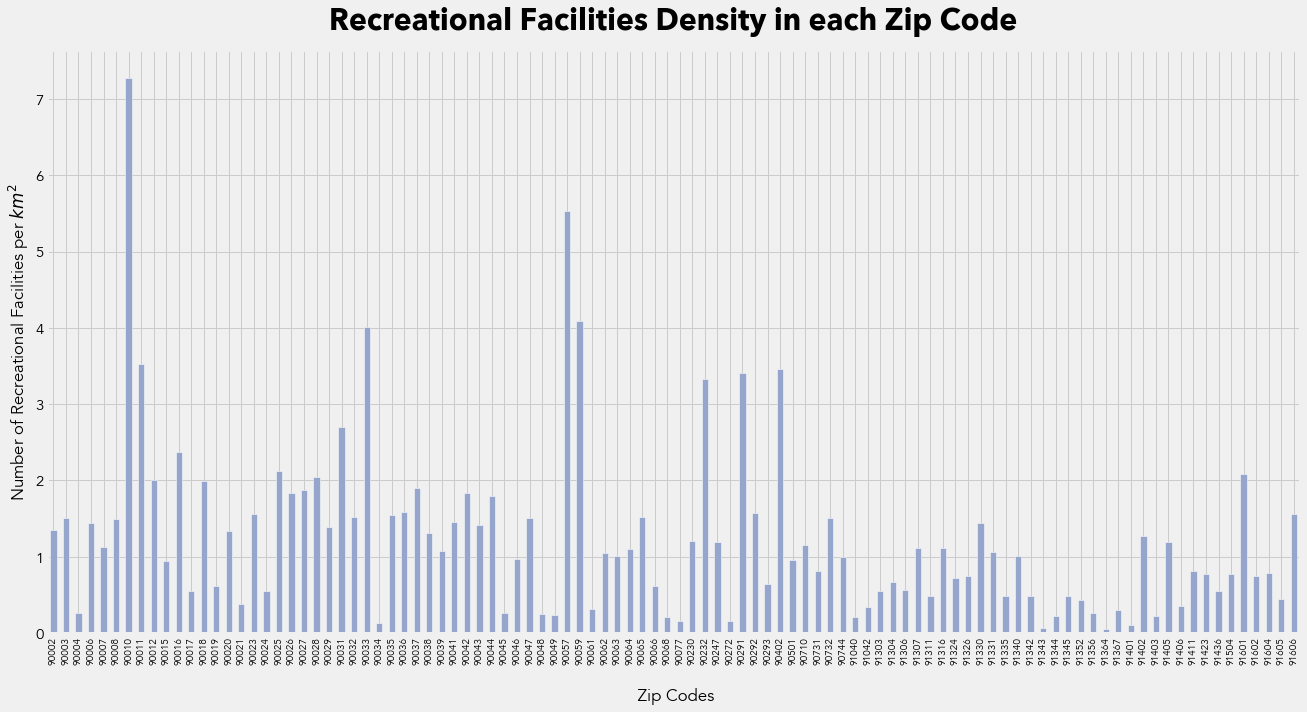

In [54]:
zipcodes_countnorm()

This graph demonstrated that there was still a larger variance across each zip code, but I thought a histogram would better convey any trends a lot clearer.

In [55]:
def zipcodes_countnorm_hist():
    countsnorm = zipgeo["Facility per km2"]
    countsnorm[countsnorm < 40].plot(kind="hist", bins=10, color=['#96A5CB'], edgecolor='white') 
    #removed 91506 as the shape file does not contain the full boundaries of the zip code leading to 8 facilities per km2 which is not accurate

    plt.yticks(fontsize=15)
    plt.xticks(fontsize=15)
    plt.title("Number of Recreational Facilities per square km in each Zip Code",family="Avenir Next",pad=20,fontsize=30)
    plt.ylabel('\n Number of Zip Codes')
    plt.xlabel('Number of Recreational Facilities per $km^{2}$')
    #90027 has the highest number of rec facilities, it is a park containing zoos, trails and other things
    plt.show()

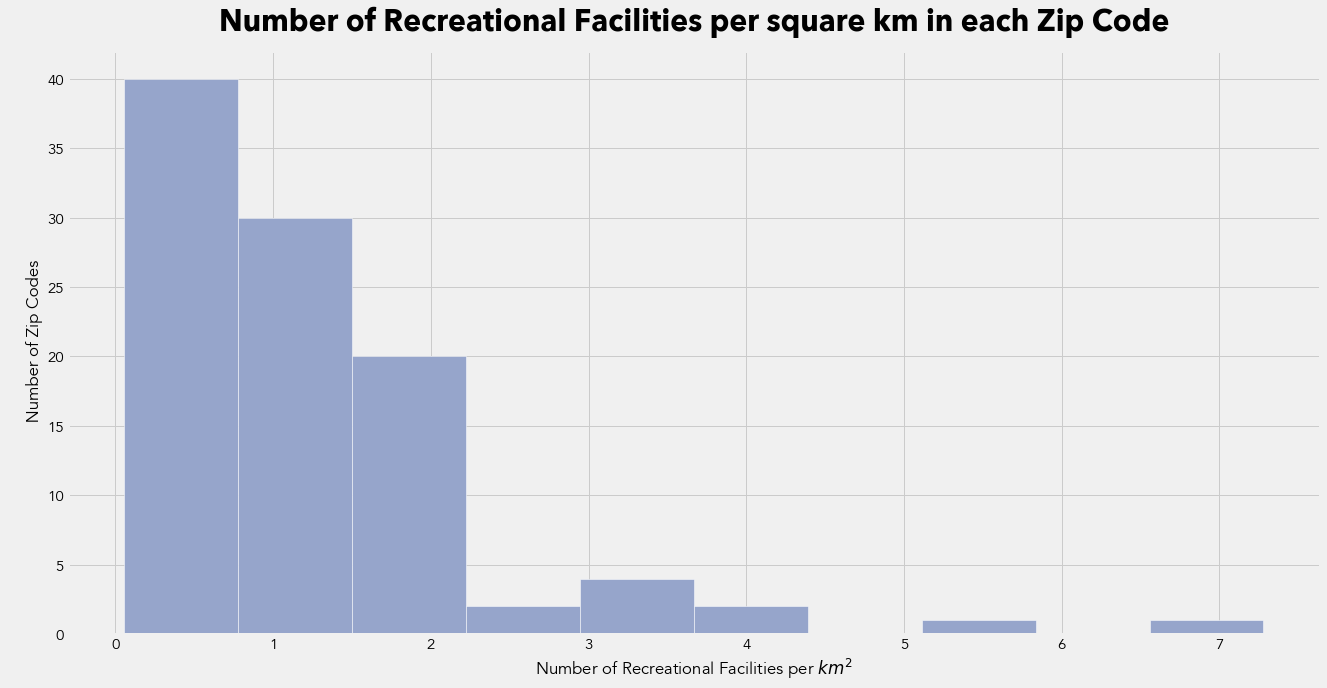

In [56]:
zipcodes_countnorm_hist()

This histogram clearly shows that the majority of zip codes contain between **0-2 facilities per $km^{2}$**. This is a much better indiciation of facility distribution that solely just considering the number of facilities irrespective of area.  

In [57]:
def zipcodes_popnorm():
    countsnorm = zipgeo["Facility per 10,000 people"]
    countsnorm[countsnorm < 100].plot(kind="hist", color=['#96A5CB'], edgecolor='white') 
    #removed 91506 as the shape file does not contain the full boundaries of the zip code leading to 8 facilities per km2 which is not accurate

    plt.yticks(fontsize=15)
    plt.xticks(fontsize=15)
    plt.title("Number of Recreational Facilities per 10,000 people in each Zip Code",family="Avenir Next",pad=20,fontsize=30)
    plt.ylabel('\n Number of Zip Codes')
    plt.xlabel('Number of Recreational Facilities per 10,000 people')
    #90027 has the highest number of rec facilities, it is a park containing zoos, trails and other things
    plt.show()

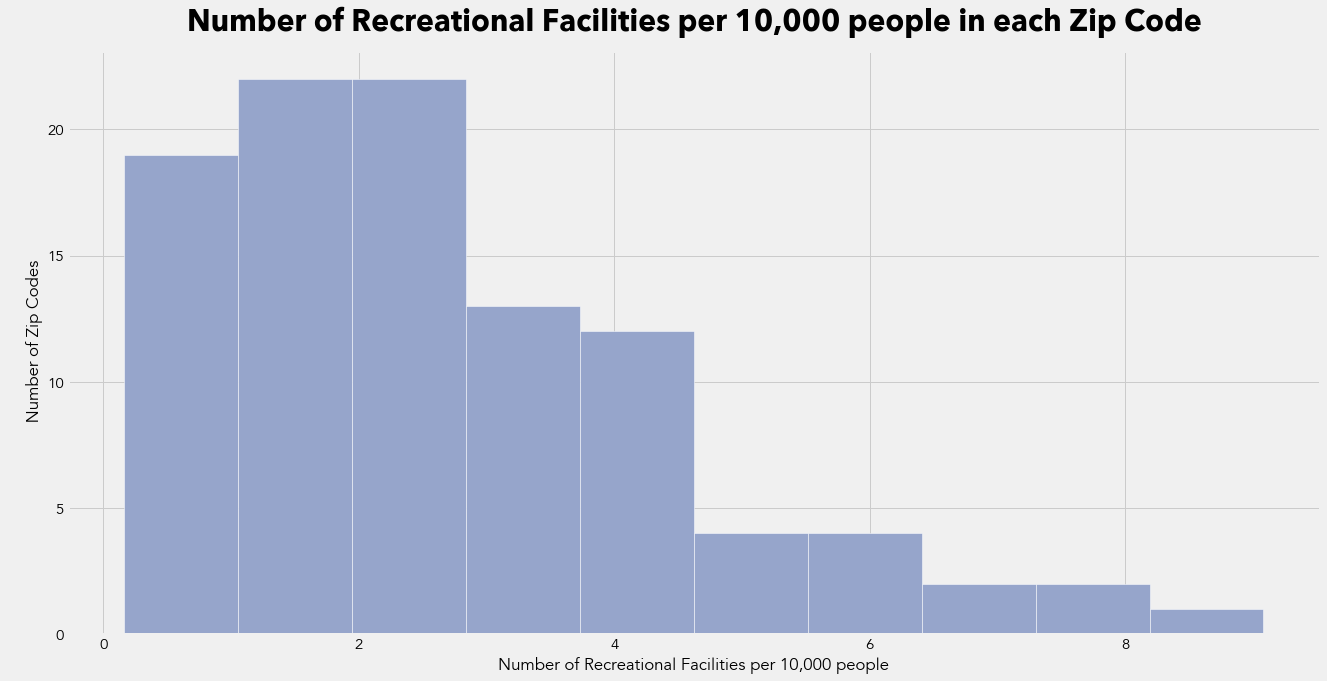

In [58]:
zipcodes_popnorm()

This histogram allows for the conclusion that there between **0-4 facilities per 10,000 people in most zip codes**.
Both histograms are a much better representation of the trends in recreational facilities. This skewness would be fairly similar when using households as the normalisation term.

# Question Two: Is the number of recreational facilities within a zip code related to its population or land area?
### Hypothesis: Yes
### Findings: Yes

# Conclusion
* Trends includes around 5 facilities per zip code, 2 facilities per 10,000 people and  one per $km^{2}$ is the most common across LA zip codes
* Los Feliz (90027) is LA's recreational facility hub and the greenest area on a coloured map of LA
* Recreational facilities are not correlated to demographics
* The high proportion of parks over other types of facilities may be due to parks being multi-use spaces that could have multiple categories
* Demographics may be better correlated to schools, employment opportunities and neighbourhood safety rather than recreational ammenties

# Further Areas of Exploration
* Incorporate other forms of census data into this analysis including average income, crime rates and school zones.
* Topographic data could be combined in the mapping
* The land area of each facility would be interesting to look into, as some areas have a few larger parks versus others that have many small ones.